# make_graphs

Create the summary figures used for the post‑estimation analysis. This notebook only keeps the data prep required for the plots below.


## 1. Load and clean data

Loads the BLP product data and standardizes the fields used in plotting.


In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.ticker import PercentFormatter, MaxNLocator


In [5]:
# Import data
clean_blp = pd.read_csv('data/raw/blp_with_subsidies.csv')

# Filter out rows we don't want
clean_blp = clean_blp[clean_blp['shares'] > 0.00001]
clean_blp = clean_blp[clean_blp['prices'] < 100000]
clean_blp = clean_blp[~clean_blp['mpg'].isna()]
clean_blp = clean_blp[~clean_blp['weight'].isna()]

# Standardize variables
clean_blp['prices'] = clean_blp['prices'] / 100000
clean_blp['subsidy'] = clean_blp['subsidy'] / 100000
clean_blp['size'] = clean_blp['size'] * 0.006944444 / 100  # Square inches to square feet in 100s
clean_blp['mpg'] = (clean_blp['mpg'] / 10)                 # mpg in 10s
clean_blp['hp'] = (clean_blp['hp'] / 100)                  # hp in 100s
clean_blp['weight'] = clean_blp['weight'] / 1000           # weight in 1000s of pounds
clean_blp['hpwt'] = clean_blp['hp'] / clean_blp['weight']

# Construct explicit ev, hybrid dummies
clean_blp['ev'] = (clean_blp['engine_type'] == 'Electric').astype(int)
clean_blp['hybrid'] = (clean_blp['engine_type'] == 'Hybrid').astype(int)

clean_blp = clean_blp[clean_blp['market_ids'] == clean_blp['product_year']]

product_data = clean_blp.copy()


In [ ]:
# Total sales in 2024 (from cleaned BLP data)
if 'clean_blp' not in globals():
    raise ValueError('clean_blp is not defined; run the data import cell first.')
sales_2024 = pd.to_numeric(clean_blp.loc[clean_blp['market_year'] == 2024, 'sales'], errors='coerce')
total_sales_2024 = float(sales_2024.sum())
print(f'Total sales in 2024: {total_sales_2024:,.0f}')
print(f'Total sales in 2024 (millions): {total_sales_2024/1_000_000:.3f}')


In [6]:
pc_panel_data = pd.read_csv('data/raw/pc_data_panel.csv')


## 2. US/Canada parts share by brand (home_mkt == 1)

Sales‑weighted pcUSCA share for top US‑market firms (plus Tesla if present).


/var/folders/hf/_vj639z54w5ffn0b7pdkzksw0000gn/T/ipykernel_30280/2451896612.py:65: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(_wavg)


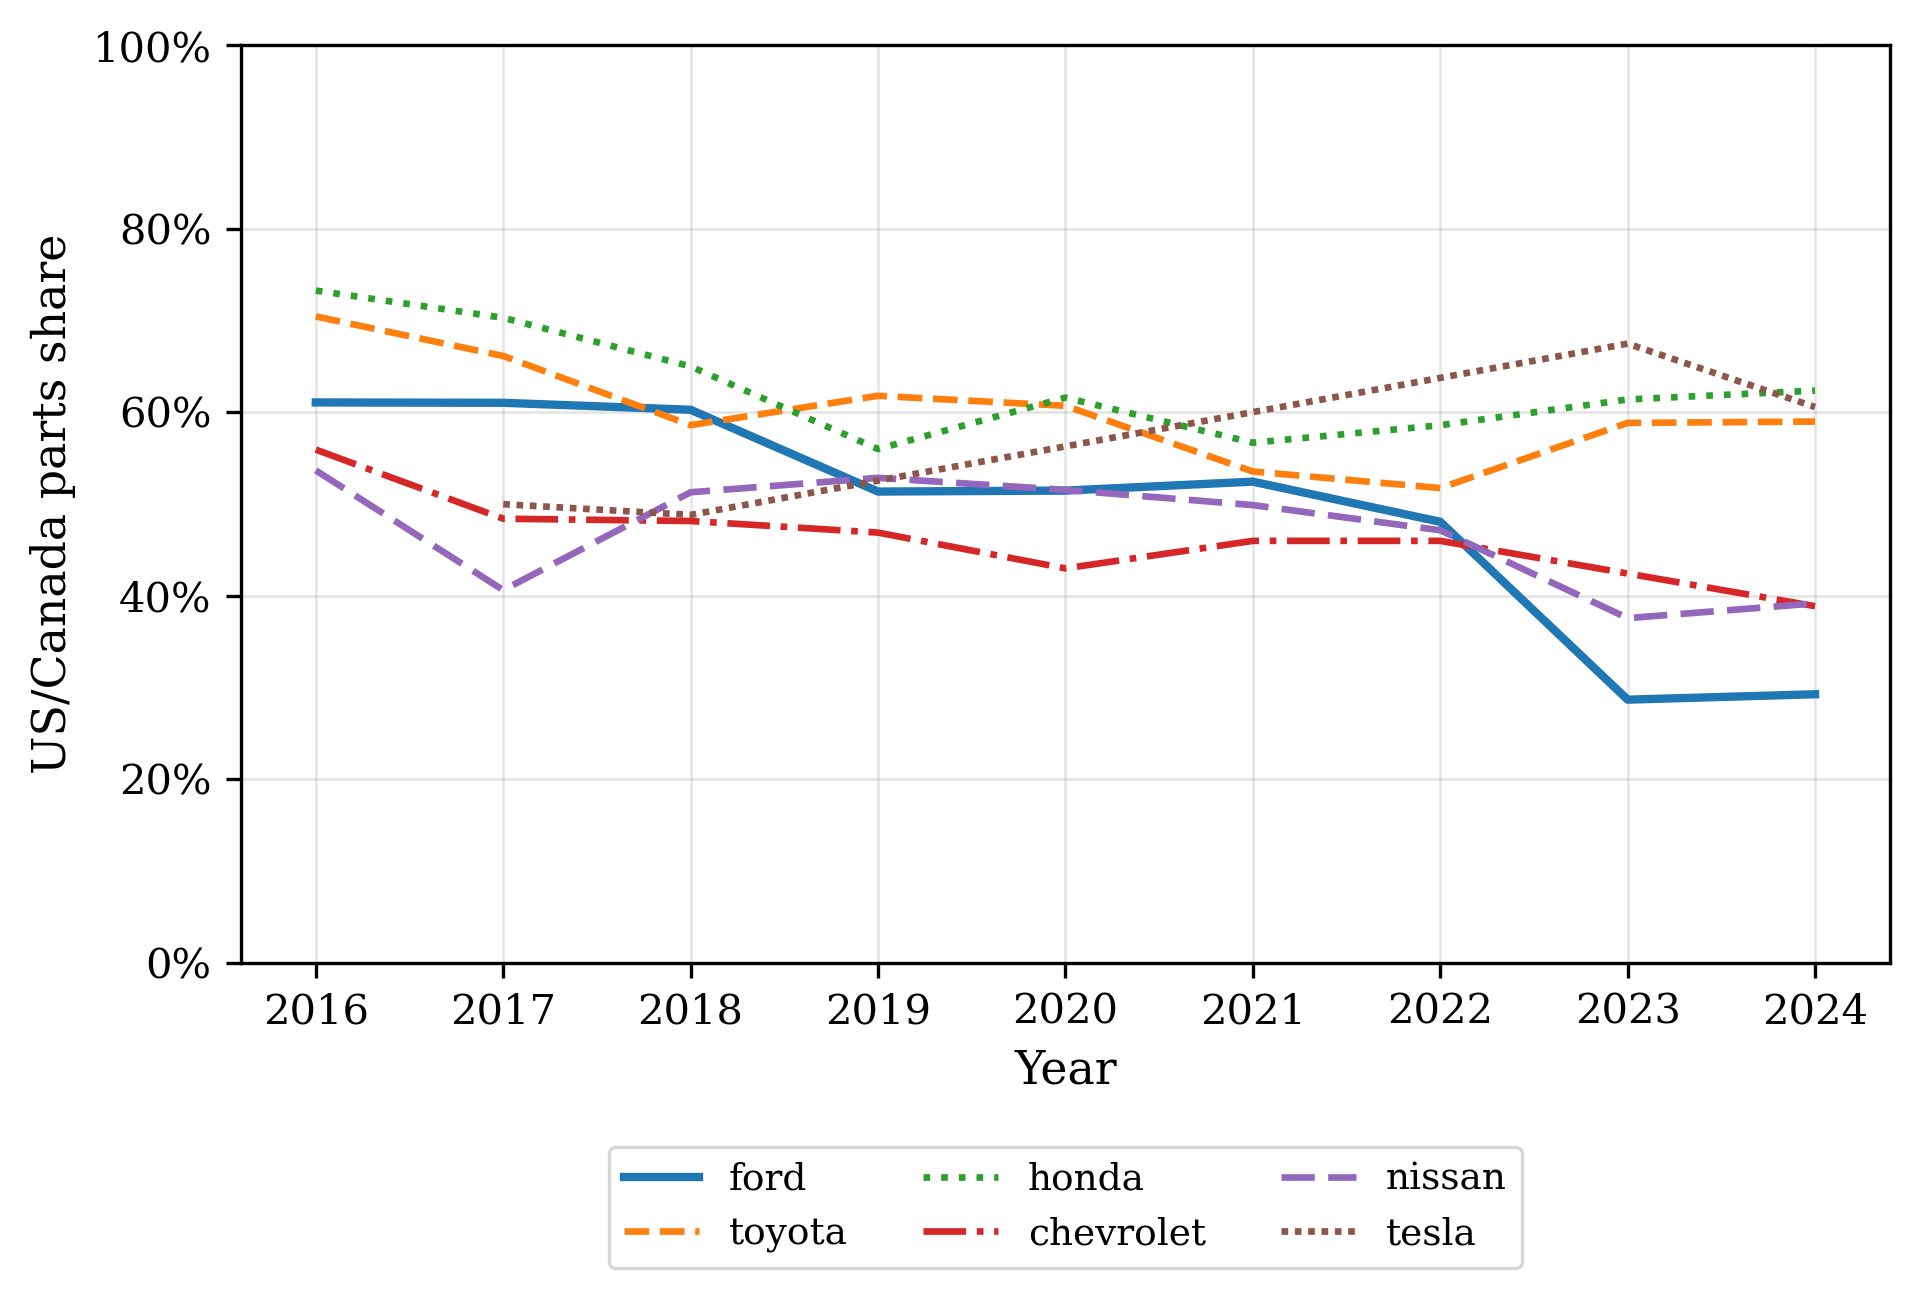

In [7]:
# ==========================================================
# Multi-firm (Top-5 brands by sales among home_mkt==1) PLUS Tesla
# Economics-journal grayscale style, single-panel figure
# ==========================================================

# ------------ House style ------------
plt.rcParams.update({
    "font.family": "serif",
    "font.size": 10,
    "axes.labelsize": 11,
    "axes.edgecolor": "black",
    "axes.linewidth": 0.8,
    "xtick.direction": "out",
    "ytick.direction": "out",
    "xtick.major.size": 3.5,
    "ytick.major.size": 3.5,
    "figure.dpi": 300,
    "savefig.dpi": 300,
    "savefig.bbox": "tight",
})

# --------- Build dataset (home_mkt == 1) ----------
prod_cols = ['product_ids', 'market_year', 'sales', 'home_mkt', 'firm_ids']
pc_cols   = ['product_ids', 'pcUSCA_pct']

df = (
    product_data[prod_cols].copy()
    .merge(pc_panel_data[pc_cols].copy(), on='product_ids', how='left')
)

df = df[df['home_mkt'] == 1].copy()
for c in ['market_year', 'sales', 'pcUSCA_pct']:
    df[c] = pd.to_numeric(df[c], errors='coerce')
df['firm_ids'] = df['firm_ids'].astype(str).str.strip()
df = df.dropna(subset=['market_year','sales','pcUSCA_pct','firm_ids'])
df = df[df['sales'] > 0]

# If pcUSCA_pct is in 0–100, uncomment:
# df['pcUSCA_pct'] = df['pcUSCA_pct'] / 100.0

# --------- Top-5 by total sales (home_mkt==1), then add Tesla if present ----------
top5 = (
    df.groupby('firm_ids', as_index=False)['sales']
      .sum()
      .sort_values('sales', ascending=False)
      .head(5)['firm_ids']
      .tolist()
)

# Try to find Tesla key (case-insensitive)
tesla_key = next((b for b in df['firm_ids'].unique() if str(b).strip().lower() == 'tesla'), None)

brands = top5.copy()
if tesla_key and tesla_key not in brands:
    brands.append(tesla_key)  # now we have 5 or 6 brands

df_plot = df[df['firm_ids'].isin(brands)].copy()

# --------- Sales-weighted series per (year, brand) ----------
def _wavg(g):
    return np.average(g['pcUSCA_pct'], weights=g['sales'])

brand_series = (
    df_plot.groupby(['market_year','firm_ids'], as_index=False)
           .apply(_wavg)
           .rename(columns={None:'pcUSCA_sales_weighted'})
)

# Wide format in the chosen order (top-5 ranking, Tesla appended if added)
wide = (
    brand_series.pivot(index='market_year', columns='firm_ids',
                       values='pcUSCA_sales_weighted')
    .reindex(columns=brands)
    .sort_index()
)

# --------- Plot ----------
fig, ax = plt.subplots(figsize=(6.5, 4.5))

# Up to 6 distinct grayscale line styles
line_styles = ['-', '--', ':', '-.', (0, (5, 2)), (0, (1, 1))]
line_widths = [2.0] + [1.6]*(len(brands)-1)  # first series slightly thicker

for i, brand in enumerate(wide.columns):
    y = wide[brand].dropna()
    x = y.index.values
    ax.plot(
        x, y.values,
        linestyle=line_styles[i % len(line_styles)],
        linewidth=line_widths[i],
        label=str(brand)
    )

ax.set_xlabel("Year")
ax.set_ylabel("US/Canada parts share")
ax.yaxis.set_major_formatter(PercentFormatter(1.0))
ax.set_ylim(0, 1)
ax.set_yticks(np.linspace(0, 1, 6))
ax.grid(True, which='major', linewidth=0.6, alpha=0.35)

leg = ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.18), ncol=3, frameon=True, fontsize=9)
leg.get_frame().set_linewidth(0.8)


fig.tight_layout()
fig.savefig("outputs/fig_pcUSCA_top5_plus_tesla_home_mkt.pdf")
fig.savefig("outputs/fig_pcUSCA_top5_plus_tesla_home_mkt.png")
plt.show()


## 3. Sales‑weighted sources of vehicles by plant country

Stacked area chart of sales shares by plant country over time.


Tidy shares saved -> outputs/year_country_shares.csv


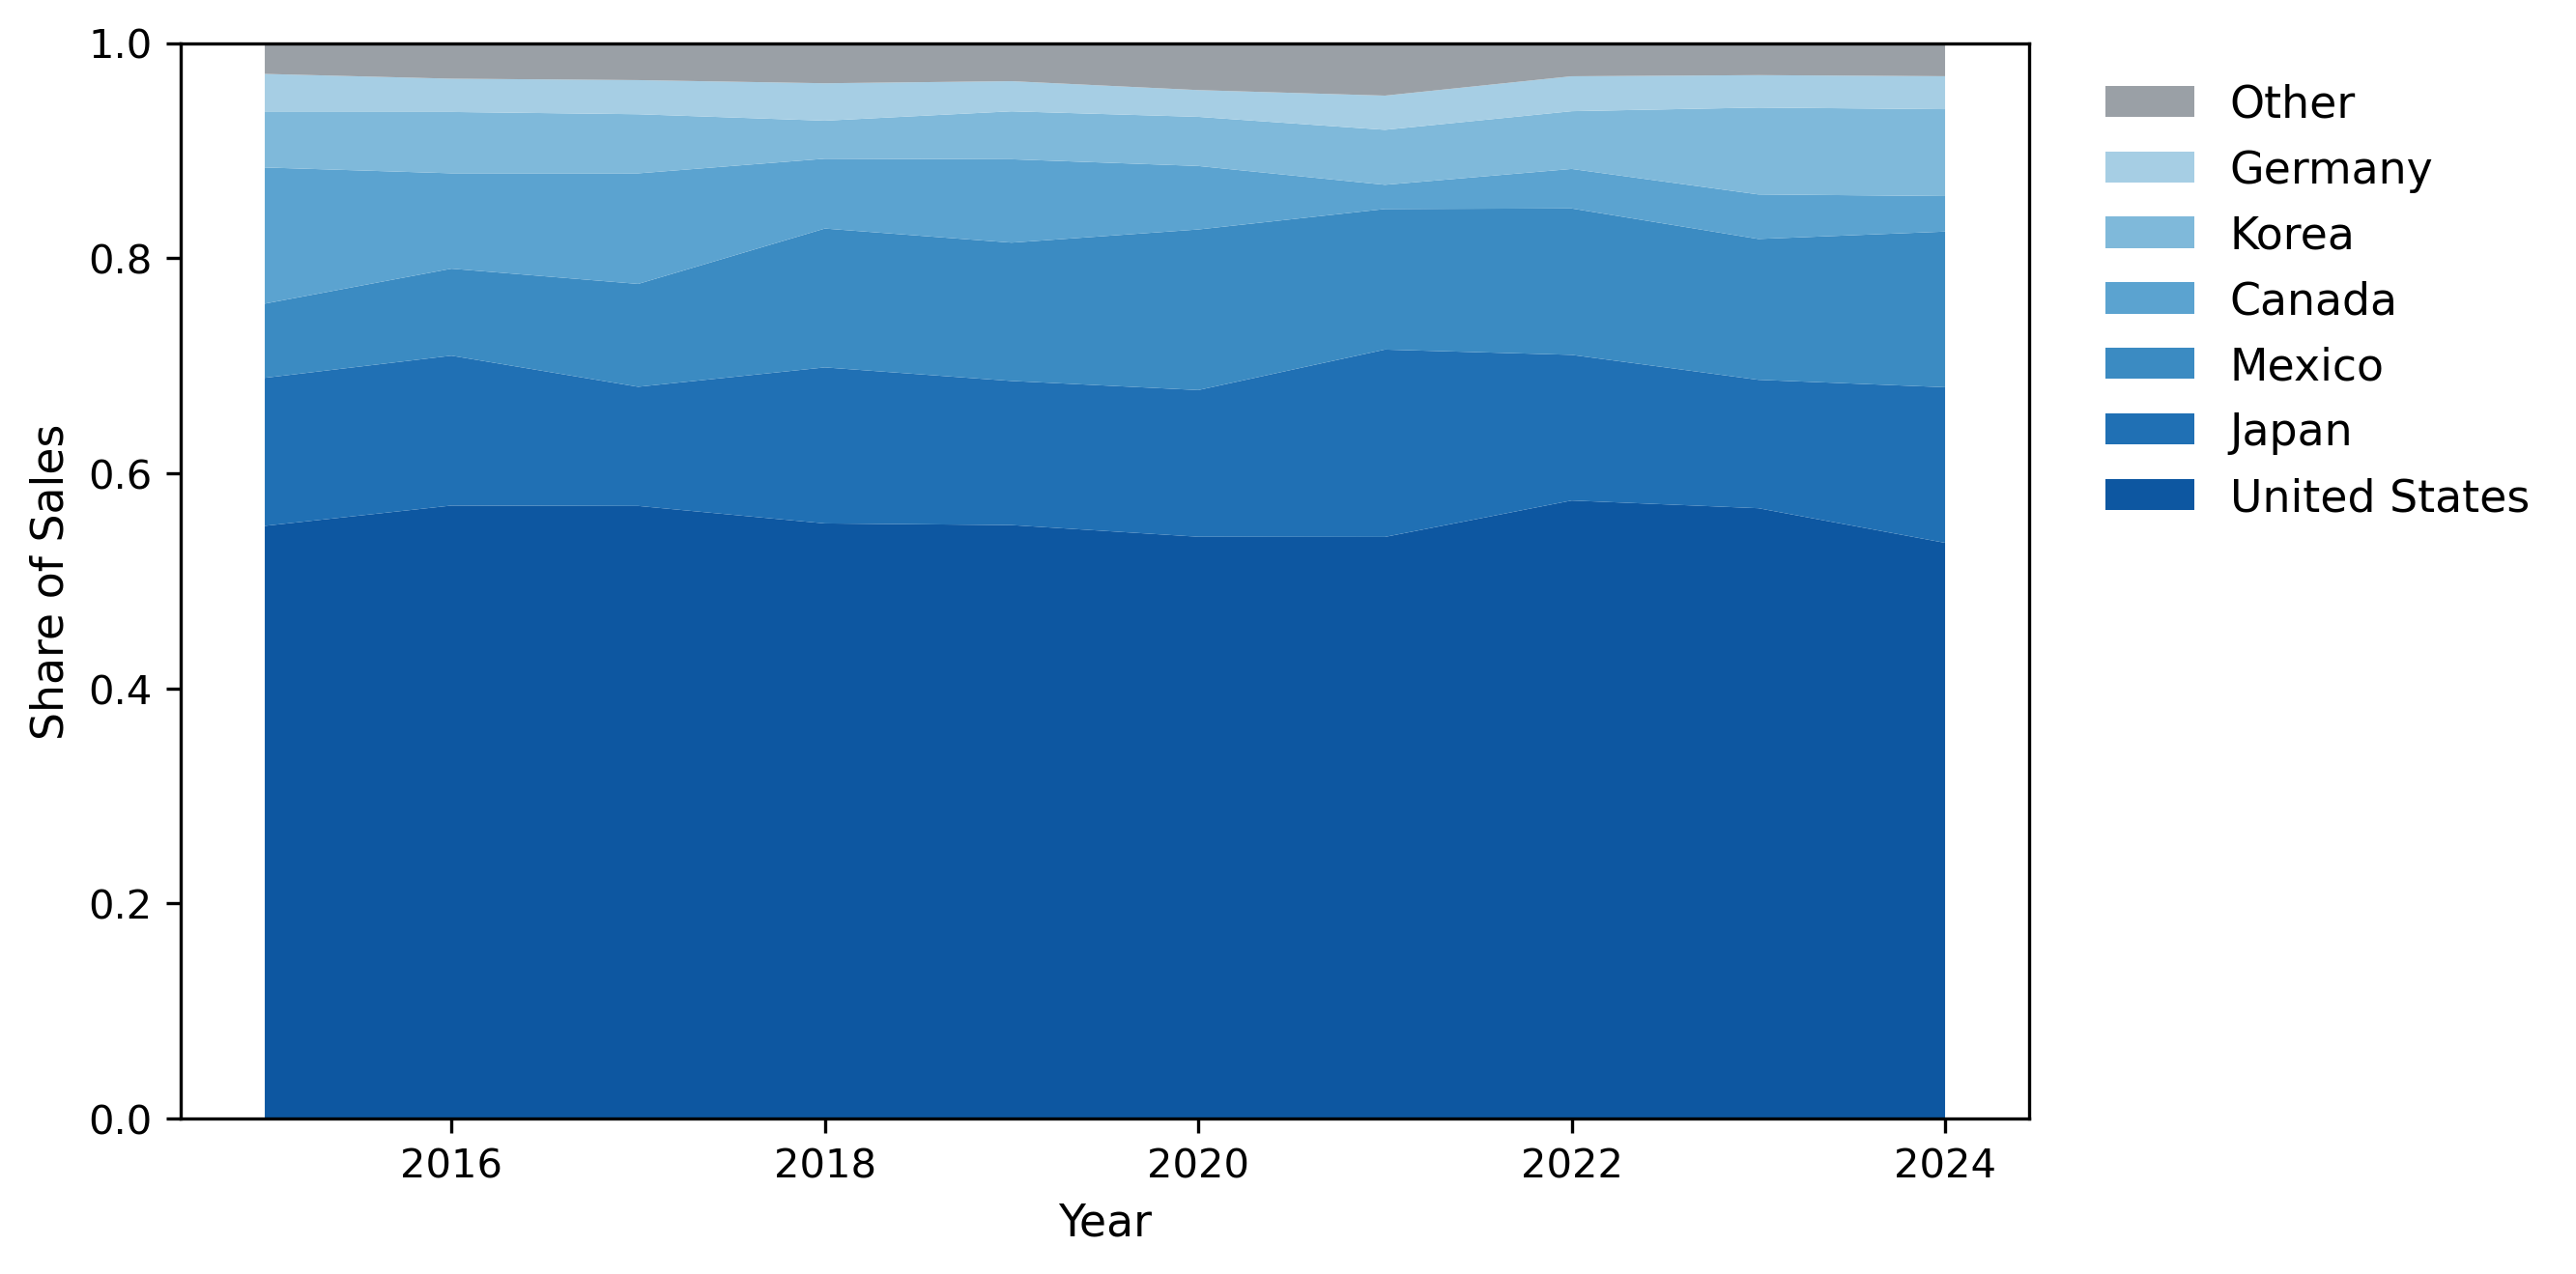

Figure saved -> outputs/sales_weighted_sources_by_year.png


In [13]:
# --- Sales-weighted sources of vehicles by year (stacked area chart) ---
# Assumes you already have `product_data` as a pandas DataFrame.


# ----------------------------
# Config
# ----------------------------
YEAR_COL = "market_year"
COUNTRY_COL = "plant_country"
WEIGHT_COL = "sales"         # use 'sales' as weights
TOP_K = 8                    # keep top K countries overall; rest grouped as "Other"
FORCE_OTHER = {"Great Britain", "Italy"}
FIGSIZE = (9, 4.5)
OUT_CSV = "outputs/year_country_shares.csv"
OUT_PNG = "outputs/sales_weighted_sources_by_year.png"

# ----------------------------
# Basic cleaning
# ----------------------------
df = clean_blp.copy()

# Ensure numeric year and weights
df[YEAR_COL] = pd.to_numeric(df[YEAR_COL], errors="coerce")
df[WEIGHT_COL] = pd.to_numeric(df[WEIGHT_COL], errors="coerce")

# Drop missing or zero/negatives in year or weights
df = df.dropna(subset=[YEAR_COL, WEIGHT_COL, COUNTRY_COL])
df = df[df[WEIGHT_COL] > 0]

# Normalize country labels a bit
df[COUNTRY_COL] = df[COUNTRY_COL].astype(str).str.strip()

# ----------------------------
# Aggregate to (year, country)
# ----------------------------
year_country_sales = (
    df.groupby([YEAR_COL, COUNTRY_COL], as_index=False)[WEIGHT_COL]
      .sum()
)

# Identify top countries overall across all years
total_by_country = (
    year_country_sales.groupby(COUNTRY_COL, as_index=False)[WEIGHT_COL]
    .sum()
    .sort_values(WEIGHT_COL, ascending=False)
)

top_countries = total_by_country[COUNTRY_COL].head(TOP_K).tolist()
# Always force these into Other, even if in top list
top_countries = [c for c in top_countries if c not in FORCE_OTHER]

# Collapse less common countries to "Other" (per year)
yc = year_country_sales.copy()
yc[COUNTRY_COL] = np.where(yc[COUNTRY_COL].isin(FORCE_OTHER), "Other", yc[COUNTRY_COL])
yc[COUNTRY_COL] = np.where(yc[COUNTRY_COL].isin(top_countries), yc[COUNTRY_COL], "Other")

# Re-aggregate after collapsing
yc = (
    yc.groupby([YEAR_COL, COUNTRY_COL], as_index=False)[WEIGHT_COL]
      .sum()
)

# Pivot to wide: rows = year, cols = country, values = sales
wide = yc.pivot(index=YEAR_COL, columns=COUNTRY_COL, values=WEIGHT_COL).fillna(0)

# Ensure a stable, readable column order: top_countries (preserve order) then "Other" if present
ordered_cols = [c for c in top_countries if c in wide.columns]
if "Other" in wide.columns and "Other" not in ordered_cols:
    ordered_cols.append("Other")
wide = wide.reindex(columns=ordered_cols)

# Compute row-wise shares
row_totals = wide.sum(axis=1).replace(0, np.nan)  # avoid div-by-zero
shares = wide.div(row_totals, axis=0).fillna(0)

# Save tidy CSV of shares (long format)
shares_long = (
    shares.reset_index()
          .melt(id_vars=[YEAR_COL], var_name="plant_country", value_name="share")
          .sort_values([YEAR_COL, "plant_country"])
)
shares_long.to_csv(OUT_CSV, index=False)
print(f"Tidy shares saved -> {OUT_CSV}")

# ----------------------------
# Plot (stacked area over time)
# ----------------------------
plt.rcParams["font.family"] = "DejaVu Sans"
plt.figure(figsize=FIGSIZE)
# Sort index so the x-axis progresses in time
shares = shares.sort_index()

# Prepare x (years) and y (list of series per country)
x = shares.index.values
ys = [shares[c].values for c in shares.columns]

# Use shades of blue for non-Other categories, grey for Other.
cols = list(shares.columns)
non_other = [c for c in cols if c != "Other"]
blues = plt.cm.Blues(np.linspace(0.35, 0.85, max(len(non_other), 1)))
blues = blues[::-1]
color_map = {c: blues[i] for i, c in enumerate(non_other)}
color_map["Other"] = "#9aa0a6"
colors = [color_map.get(c, "#9aa0a6") for c in cols]

plt.stackplot(x, ys, labels=shares.columns, colors=colors)
plt.xlabel("Year")
plt.ylabel("Share of Sales")
plt.ylim(0, 1)
handles, labels = plt.gca().get_legend_handles_labels()
plt.legend(handles[::-1], labels[::-1], loc="upper left", bbox_to_anchor=(1.02, 1.0), frameon=False, fontsize=11)
plt.tight_layout()
plt.savefig(OUT_PNG, dpi=200, bbox_inches="tight")
plt.show()
print(f"Figure saved -> {OUT_PNG}")


# --- Average EV subsidy by firm and year (US-assembled only) ---

This plot uses the `subsidy` column, restricting to EVs assembled in the United States (`plant_country == 'United States'`). We compute the sales-weighted average subsidy by firm-year (weights = `sales`).

In [22]:
YEAR_COL = "market_year"
FIRM_COL = "firm_ids"
SUBSIDY_COL = "subsidy"
EV_COL = "ev"
COUNTRY_COL = "plant_country"
WEIGHT_COL = "sales"
TOP_FIRMS = 8
OUT_CSV = "outputs/avg_ev_subsidy_by_firm_year.csv"
OUT_CSV = "outputs/avg_ev_subsidy_by_firm_year.csv"

df = clean_blp.copy()
df[YEAR_COL] = pd.to_numeric(df[YEAR_COL], errors="coerce")
df[WEIGHT_COL] = pd.to_numeric(df[WEIGHT_COL], errors="coerce")
df[SUBSIDY_COL] = pd.to_numeric(df[SUBSIDY_COL], errors="coerce")
df[EV_COL] = pd.to_numeric(df[EV_COL], errors="coerce").fillna(0)
df[COUNTRY_COL] = df[COUNTRY_COL].astype(str).str.strip()

df = df[df[EV_COL] == 1]
# Apply domestic assembly restriction only from 2023 onward
#df = df[(df[YEAR_COL] < 2023) | (df[COUNTRY_COL] == "United States")]
df = df.dropna(subset=[YEAR_COL, WEIGHT_COL, SUBSIDY_COL, FIRM_COL])
df = df[df[WEIGHT_COL] > 0]

grp = (
    df.groupby([YEAR_COL, FIRM_COL], as_index=False)
      .apply(lambda d: pd.Series({
          "avg_subsidy": (d[SUBSIDY_COL] * d[WEIGHT_COL]).sum() / d[WEIGHT_COL].sum()
      }))
)

# Keep top firms by total sales within filtered sample
top_firms = (
    df.groupby(FIRM_COL)[WEIGHT_COL].sum()
      .sort_values(ascending=False)
      .head(TOP_FIRMS)
      .index.tolist()
)
grp = grp[grp[FIRM_COL].isin(top_firms)]

pivot = grp.pivot(index=YEAR_COL, columns=FIRM_COL, values="avg_subsidy").sort_index()
table = pivot.T
table = table.fillna(0)
table.to_csv(OUT_CSV)
print(f"Saved -> {OUT_CSV}")

display(table)



Saved -> outputs/avg_ev_subsidy_by_firm_year.csv


/var/folders/hf/_vj639z54w5ffn0b7pdkzksw0000gn/T/ipykernel_30280/1090084844.py:26: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda d: pd.Series({


market_year,2015,2016,2017,2018,2019,2020,2021,2022,2023,2024
firm_ids,,,,,,,,,,
cadillac,0.000,0.000,0.000,0.000,0.00000,0.00000,0.000,0.000000,0.075000,0.075000
chevrolet,0.075,0.075,0.075,0.075,0.04200,0.00465,0.000,0.000000,0.075000,0.018344
ford,0.075,0.075,0.075,0.000,0.00000,0.00000,0.075,0.046644,0.026835,0.075000
hyundai,0.000,0.000,0.075,0.075,0.07500,0.07500,0.075,0.046644,0.000000,0.000000
kia,0.075,0.075,0.075,0.075,0.07500,0.07500,0.075,0.046644,0.000000,0.000000
nissan,0.075,0.075,0.075,0.075,0.07500,0.07500,0.075,0.046644,0.075000,0.037500
tesla,0.075,0.075,0.075,0.075,0.02805,0.00000,0.000,0.000000,0.075000,0.075000
volkswagen,0.075,0.075,0.075,0.075,0.07500,0.00000,0.075,0.046644,0.075000,0.075000


## 4. Sales‑weighted EV/SUV/Truck/Hybrid shares

Time series of category shares of total sales.


Saved -> outputs/year_ev_suv_truck_hybrid_shares.csv


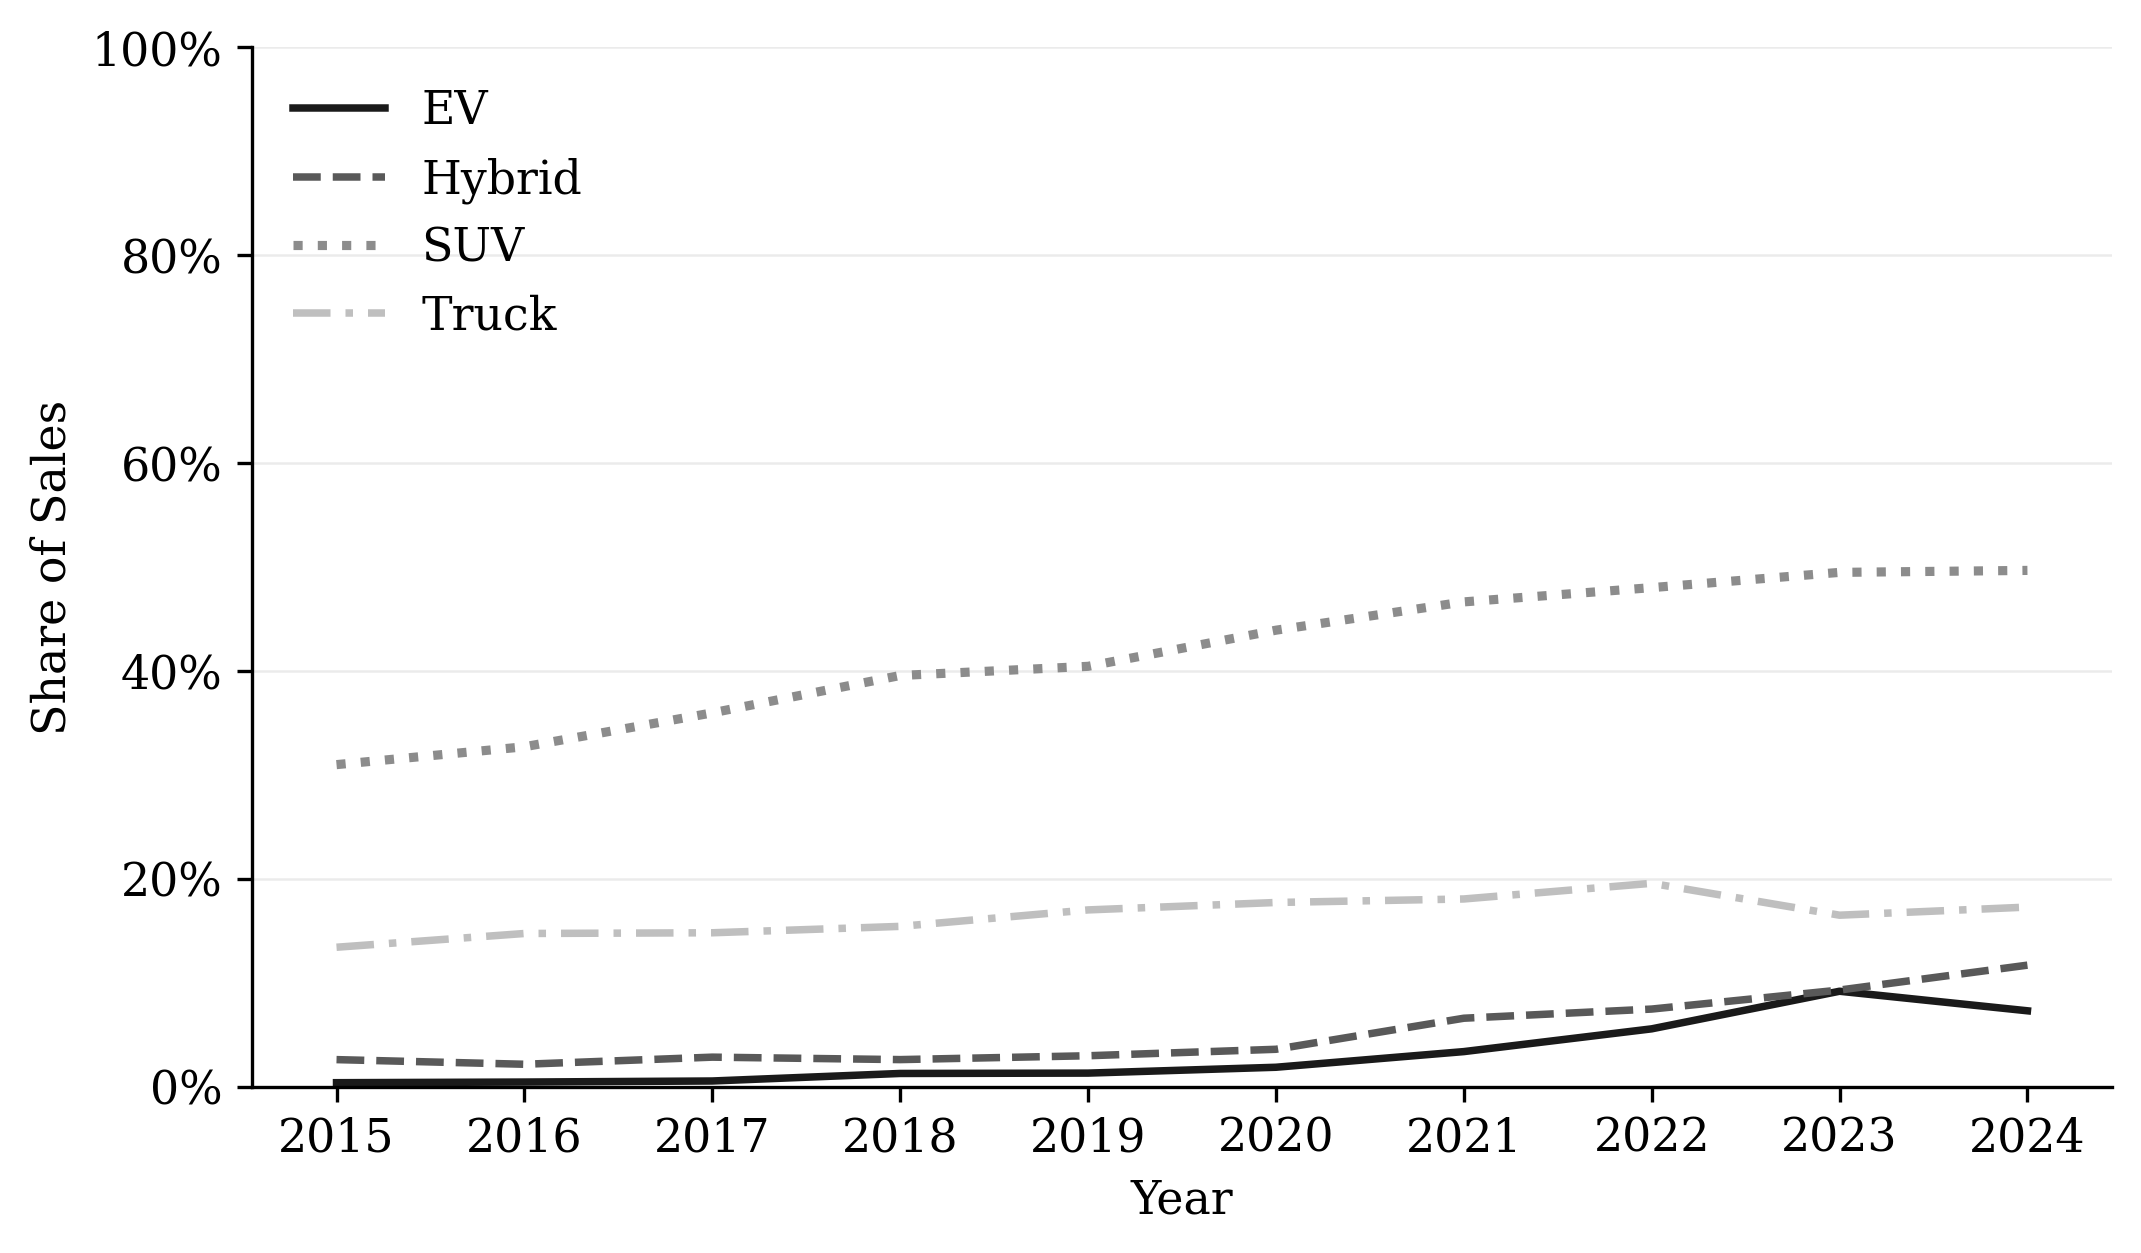

In [6]:
# ----------------------------
# Config
# ----------------------------
YEAR_COL = "market_year"
SALES_COL = "sales"
VEH_TYPE_COL = "vehicle_type"
EV_COL = "ev"
HYB_COL = "hybrid"

OUT_PNG = "outputs/sales_weighted_ev_suv_truck_hybrid_shares.png"
OUT_CSV = "outputs/year_ev_suv_truck_hybrid_shares.csv"
FIGSIZE = (8, 4.5)

# ----------------------------
# Prep / cleaning
# ----------------------------
df = product_data.copy()

df[YEAR_COL] = pd.to_numeric(df[YEAR_COL], errors="coerce")
df[SALES_COL] = pd.to_numeric(df[SALES_COL], errors="coerce")
df[EV_COL] = pd.to_numeric(df[EV_COL], errors="coerce").fillna(0)
df[HYB_COL] = pd.to_numeric(df[HYB_COL], errors="coerce").fillna(0)

df = df.dropna(subset=[YEAR_COL, SALES_COL])
df = df[df[SALES_COL] > 0].copy()

df[VEH_TYPE_COL] = df[VEH_TYPE_COL].astype(str).str.strip()
vt = df[VEH_TYPE_COL].str.lower()

# Robust-ish matching for vehicle_type labels
is_suv = vt.str.contains(r"\bsuv\b") | vt.str.contains("sport utility")
is_truck = vt.str.contains(r"\btruck\b") | vt.str.contains("pickup")

is_ev = df[EV_COL].astype(int) == 1
is_hybrid = df[HYB_COL].astype(int) == 1

# ----------------------------
# Aggregate sales-weighted shares by year
# ----------------------------
g = df.groupby(YEAR_COL, as_index=False).agg(
    total_sales=(SALES_COL, "sum"),
    ev_sales=(SALES_COL, lambda s: s[is_ev.loc[s.index]].sum()),
    hybrid_sales=(SALES_COL, lambda s: s[is_hybrid.loc[s.index]].sum()),
    suv_sales=(SALES_COL, lambda s: s[is_suv.loc[s.index]].sum()),
    truck_sales=(SALES_COL, lambda s: s[is_truck.loc[s.index]].sum()),
)

for k in ["ev", "hybrid", "suv", "truck"]:
    g[f"{k}_share"] = g[f"{k}_sales"] / g["total_sales"]

g = g.sort_values(YEAR_COL)
g.to_csv(OUT_CSV, index=False)
print(f"Saved -> {OUT_CSV}")

# ----------------------------
# Plot (grayscale + distinct linestyles)
# ----------------------------
plt.rcParams.update({
    "font.size": 11,
    "axes.spines.top": False,
    "axes.spines.right": False,
    "axes.linewidth": 0.8,
    "xtick.direction": "out",
    "ytick.direction": "out",
})

fig, ax = plt.subplots(figsize=FIGSIZE)

series = [
    ("EV",     "ev_share",     "-",             1.8),
    ("Hybrid", "hybrid_share", "--",            1.8),
    ("SUV",    "suv_share",    ":",             2.2),
    ("Truck",  "truck_share",  (0, (5, 2, 1, 2)), 1.8),  # dash-dot-ish
]

# Use varying grayscale levels (still monochrome) + distinct linestyles
grays = ["0.10", "0.35", "0.55", "0.75"]

for (gray, (label, col, ls, lw)) in zip(grays, series):
    ax.plot(g[YEAR_COL], g[col], label=label, color=gray, linestyle=ls, linewidth=lw)


ax.set_xlabel("Year")
ax.set_ylabel("Share of Sales")
ax.set_ylim(0, 1)

ax.yaxis.set_major_formatter(PercentFormatter(1.0, decimals=0))
ax.yaxis.set_major_locator(MaxNLocator(nbins=5))
ax.xaxis.set_major_locator(MaxNLocator(integer=True))

ax.grid(axis="y", alpha=0.25, linewidth=0.6)
ax.grid(axis="x", visible=False)

ax.legend(frameon=False, ncol=1, loc="upper left")


plt.show()


# --- Foreign parts sources (US-assembled vehicles) ---

Uses `pcUSCA_pct` as the domestic share and any other `*_pct` columns in `pc_data_panel.csv` as observed foreign sources.
Unobserved = (1 - pcUSCA_pct) - sum(observed foreign sources). Plotted as a stacked area chart by year.

In [ ]:
YEAR_COL = "year"
COUNTRY_COL = "plant_country"
WEIGHT_COL = "sales"
OUT_PNG = "outputs/foreign_parts_sources_us_assembled.png"

pc_panel = pd.read_csv("data/raw/pc_data_panel.csv")
pc_panel[YEAR_COL] = pd.to_numeric(pc_panel[YEAR_COL], errors="coerce")
pc_panel[COUNTRY_COL] = pc_panel[COUNTRY_COL].astype(str).str.strip()
if WEIGHT_COL in pc_panel.columns:
    pc_panel[WEIGHT_COL] = pd.to_numeric(pc_panel[WEIGHT_COL], errors="coerce")
else:
    pc_panel[WEIGHT_COL] = 1.0
pc_panel["pcUSCA_pct"] = pd.to_numeric(pc_panel["pcUSCA_pct"], errors="coerce")

# Restrict to US-assembled vehicles
pc_panel = pc_panel[pc_panel[COUNTRY_COL] == "United States"].copy()
pc_panel = pc_panel.dropna(subset=[YEAR_COL, "pcUSCA_pct"])
pc_panel[WEIGHT_COL] = pc_panel[WEIGHT_COL].fillna(1.0)
pc_panel = pc_panel[pc_panel[WEIGHT_COL] > 0]

# If pcUSCA_pct is in 0-100, scale to 0-1
if pc_panel["pcUSCA_pct"].max() > 1.0:
    pc_panel["pcUSCA_pct"] = pc_panel["pcUSCA_pct"] / 100.0

# Observed foreign sources: any *_pct columns besides pcUSCA_pct
pct_cols = [c for c in pc_panel.columns if c.endswith("_pct")]
observed_cols = [c for c in pct_cols if c != "pcUSCA_pct"]

def wavg(series, weights):
    s = series.to_numpy(dtype=float)
    w = weights.to_numpy(dtype=float)
    mask = np.isfinite(s) & np.isfinite(w)
    if mask.sum() == 0:
        return np.nan
    return float(np.nansum(s[mask] * w[mask]) / np.nansum(w[mask]))

rows = []
for y, g in pc_panel.groupby(YEAR_COL):
    row = {YEAR_COL: y}
    for c in observed_cols:
        row[c] = wavg(g[c], g[WEIGHT_COL])
    row["pcUSCA_pct"] = wavg(g["pcUSCA_pct"], g[WEIGHT_COL])
    rows.append(row)

avg = pd.DataFrame(rows).sort_values(YEAR_COL)
avg["foreign_total"] = 1.0 - avg["pcUSCA_pct"]
avg["observed_foreign"] = avg[observed_cols].sum(axis=1) if observed_cols else 0.0
avg["unobserved"] = avg["foreign_total"] - avg["observed_foreign"]

stack_cols = observed_cols + ["unobserved"]

def _label(c):
    if c == "unobserved":
        return "Unobserved"
    name = c
    if name.startswith("pc"):
        name = name[2:]
    if name.endswith("_pct"):
        name = name[:-4]
    return name

labels = [_label(c) for c in stack_cols]

plt.rcParams["font.family"] = "DejaVu Sans"
plt.figure(figsize=(8, 4.5))
x = avg[YEAR_COL].to_numpy()
ys = [avg[c].to_numpy() for c in stack_cols]

n_obs = max(len(stack_cols) - 1, 1)
colors = list(plt.cm.tab20(np.linspace(0, 1, n_obs)))
colors.append("#9aa0a6")

plt.stackplot(x, ys, labels=labels, colors=colors)
plt.xlabel("Year")
plt.ylabel("Average foreign parts share")
plt.ylim(0, 1)
handles, labels = plt.gca().get_legend_handles_labels()
plt.legend(handles[::-1], labels[::-1], loc="upper left", bbox_to_anchor=(1.02, 1.0), frameon=False, fontsize=10)
plt.tight_layout()
plt.savefig(OUT_PNG, dpi=200, bbox_inches="tight")
plt.show()
print(f"Figure saved -> {OUT_PNG}")


## Foreign Parts Sources (Cost-Side Panel)
Stacked chart of average foreign parts share by year, using `pcOth1_code1` and `pcOth1_pct1` with an `unobserved` residual (1 - pcUSCA_pct minus observed shares).


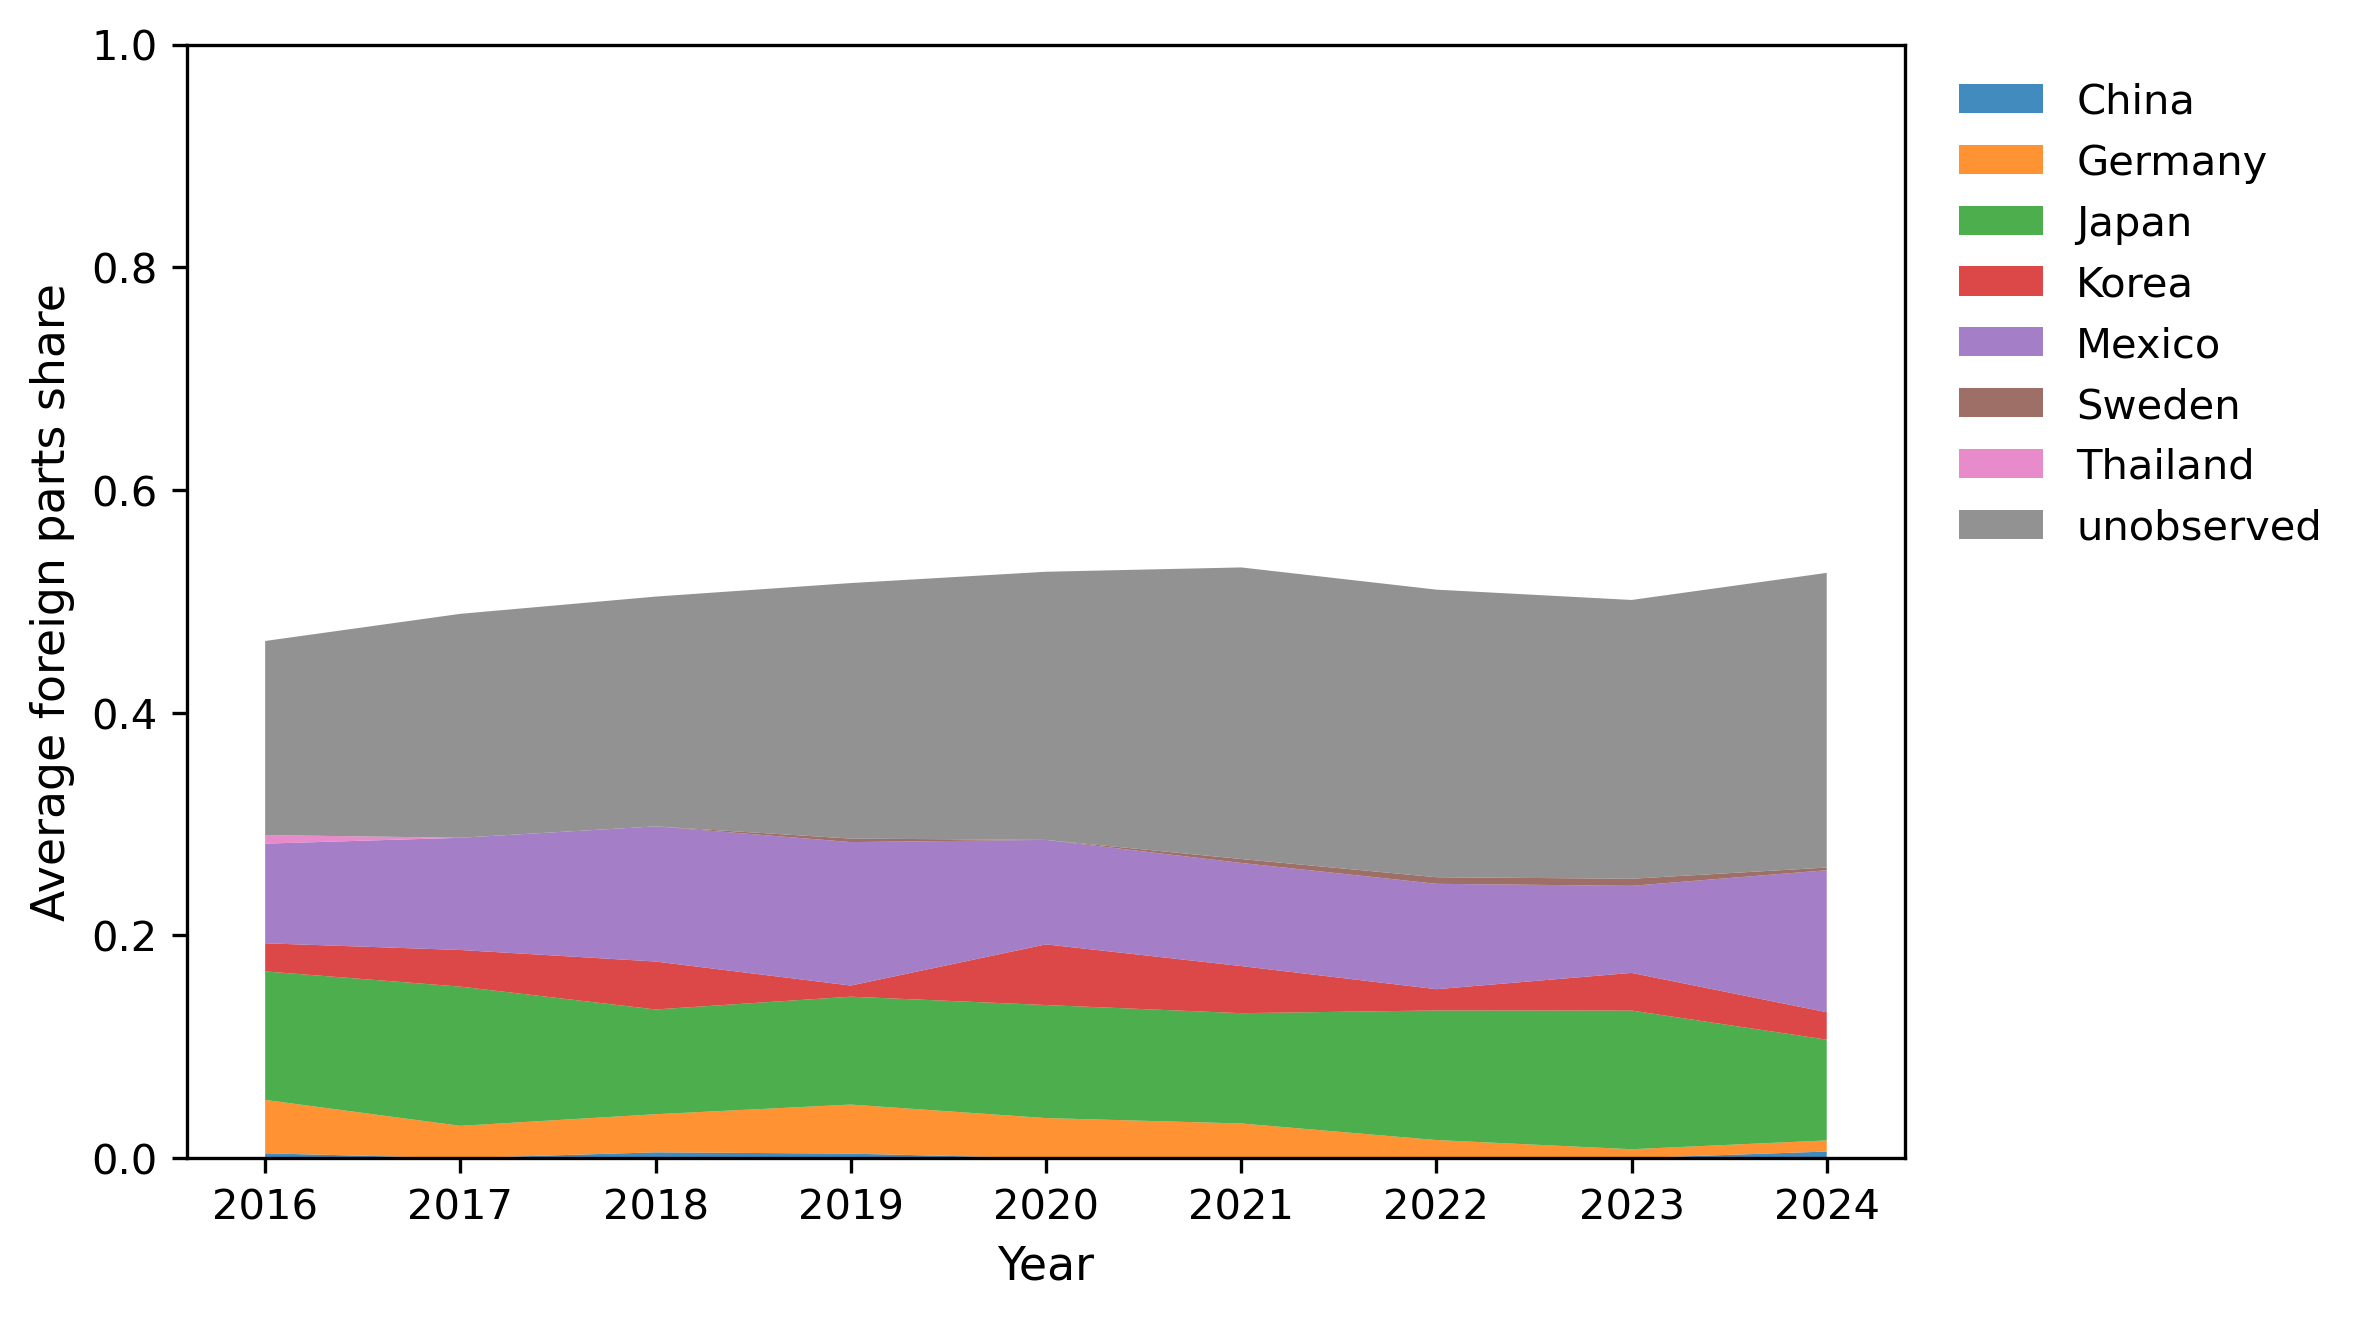

In [48]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

cs_panel = pd.read_csv('data/raw/cost_side_panel.csv')
cs_panel['year'] = pd.to_numeric(cs_panel['year'], errors='coerce')
cs_panel['pcUSCA_pct'] = pd.to_numeric(cs_panel['pcUSCA_pct'], errors='coerce')
cs_panel['pcOth1_pct1'] = pd.to_numeric(cs_panel['pcOth1_pct1'], errors='coerce')
cs_panel['pcOth1_code1'] = cs_panel['pcOth1_code1'].astype(str).str.strip()

cs_panel = cs_panel.dropna(subset=['year'])
year_counts = cs_panel.groupby('year', dropna=False).size().rename('n')

# Total foreign share per year (average over vehicles)
foreign_total = (1.0 - cs_panel['pcUSCA_pct']).groupby(cs_panel['year']).mean()

# Observed shares by country (sum of pcOth1_pct1 over vehicles / N_year)
obs_sum = (
    cs_panel.groupby(['year', 'pcOth1_code1'])['pcOth1_pct1']
    .sum()
    .rename('sum_pct')
    .reset_index()
)
obs_sum = obs_sum.merge(year_counts.reset_index(), on='year', how='left')
obs_sum['share'] = obs_sum['sum_pct'] / obs_sum['n']

obs_pivot = obs_sum.pivot(index='year', columns='pcOth1_code1', values='share').fillna(0.0)
obs_pivot = obs_pivot.sort_index()

observed_total = obs_pivot.sum(axis=1)
unobserved = (foreign_total.reindex(obs_pivot.index) - observed_total).clip(lower=0.0)

stack_df = obs_pivot.copy()
stack_df['unobserved'] = unobserved

years = stack_df.index.to_numpy(dtype=int)

# Order observed sources by average magnitude (descending), keep unobserved last
observed_cols = [c for c in stack_df.columns if c != 'unobserved']
order = (stack_df[observed_cols].mean(axis=0).sort_values(ascending=False).index.tolist())
labels = order + ['unobserved']
values = [stack_df[c].to_numpy(dtype=float) for c in labels]

# Colors: observed palette + gray for unobserved
obs_colors = [
    '#4e79a7', '#f28e2b', '#59a14f', '#e15759',
    '#edc948', '#76b7b2', '#b07aa1', '#9c755f', '#bab0ac'
]
colors = obs_colors[:len(order)] + ['#b0b0b0']

fig, ax = plt.subplots(figsize=(8, 4.5))
ax.set_axisbelow(True)
ax.grid(axis='y', color='0.9', linewidth=0.8)

# Stacked areas with black outlines to mimic the reference style
polys = ax.stackplot(
    years,
    values,
    labels=labels,
    colors=colors,
    alpha=0.9,
    linewidth=0.6,
    edgecolor='white',
)

ax.set_xlabel('Year')
ax.set_ylabel('Average foreign parts share')
ax.set_ylim(0, max(1.0, float((foreign_total.max() if len(foreign_total) else 1.0))))
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.legend(frameon=True, loc='upper center', bbox_to_anchor=(0.5, -0.2), ncol=3)
plt.tight_layout()
plt.show()
